# Laboratorio 5. Clasificación de tweets usando mineria de texto

integrantes: 

    - Francis Aguilar - 22243 
    - Angela García -22869 
    - Cesar Lopez - 22535

enlace al repositorio: https://github.com/angelargd8/lab5-ds

In [2]:
# !pip install nltk
# !pip install wordcloud
# !pip install emoji

In [3]:
import pandas as pd 
import numpy as np 
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, make_scorer, precision_score, recall_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC


In [4]:
# Descargar stopwords de NLTK
nltk.download("stopwords")
stop_words   = set(stopwords.words("english"))
stop_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

# Dataset de tweets

El conjunto de datos está formado por más de 10 500 filas y 5 columnas: 

id: El identificador del tweet

keyword: una palabra clave del tweet, puede estar en blanco 

location: la ubicación desde donde fue enviado el tweet 

text: El texto del tweet 

target: La etiqueta de clasificación que especifica si el tweet se trata de un desastre real (1) o no (0). 

In [5]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Analisis exploratorio

In [6]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [9]:
df.value_counts()

id     keyword  location                       text                                                                                                         target
48     ablaze   Birmingham                     @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C                                                      1         1
49     ablaze   Est. September 2012 - Bristol  We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw                                          0         1
50     ablaze   AFRICA                         #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi                           1         1
52     ablaze   Philadelphia, PA               Crying out for more! Set me ablaze                                                                           0         1
53     ablaze   London, UK                     On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N                                 0        

In [10]:
#contar valores duplicadosss
df.duplicated().sum()

np.int64(0)

In [11]:
#contar valores nulos
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [12]:
# pass si es keyword nulo, porque es opcional, agregarle un valor por defecto
df["keyword"].fillna("sin keyword", inplace=True)

# colocar no location
df["location"].fillna("sin location", inplace=True)

C:\Users\MSI\AppData\Local\Temp\ipykernel_13024\2483260786.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["keyword"].fillna("sin keyword", inplace=True)
C:\Users\MSI\AppData\Local\Temp\ipykernel_13024\2483260786.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exampl

In [13]:
#tamanio del dataset
df.shape

(7613, 5)

In [14]:
#tablas de contingencia
#frecuencias absolutas
pd.crosstab(df["keyword"], df["target"]).head(10)


target,0,1
keyword,,
ablaze,23,13
accident,11,24
aftershock,34,0
airplane%20accident,5,30
ambulance,18,20
annihilated,23,11
annihilation,19,10
apocalypse,23,9
armageddon,37,5


El resultado es una tabla con conteos por conbinacion de keyword y target

In [15]:
pd.crosstab(df["keyword"], df["target"], normalize="index").head(10)


target,0,1
keyword,,
ablaze,0.638889,0.361111
accident,0.314286,0.685714
aftershock,1.000000,0.000000
airplane%20accident,0.142857,0.857143
ambulance,0.473684,0.526316
annihilated,0.676471,0.323529
annihilation,0.655172,0.344828
apocalypse,0.718750,0.281250
armageddon,0.880952,0.119048


el resultado de esta tabla de proporcion es que para keyword, que proporcion pertenece a target 0 vs target 1

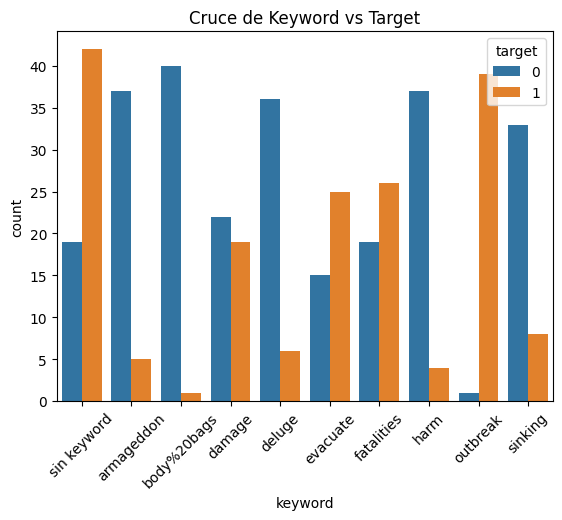

In [16]:
import seaborn as sns

top_keywords = df["keyword"].value_counts().head(10).index
sns.countplot(data=df[df["keyword"].isin(top_keywords)], 
              x="keyword", hue="target")
plt.xticks(rotation=45)
plt.title("Cruce de Keyword vs Target")
plt.show()


Lo que se logra observar es la propocion para pertenece a target 0 o 1. Siendo, la target si el tweet trata de un desastre real cuando es 1 y 0 cuando no lo es. Para cada palabra se nota una gran diferencia de distribución. Y las palabras como armageddon, deluge, harm la mayoria de tweets están en contextos que no son de desastres reales, podrían ser relacionados con contextos humoristicos, ironía o metafóricos. 
Mientras, las keywords más ligadas a los desastres faltales son evacuate, fatalities y outbreak lo que puede que estan más relacionadas a reportes de emergencias reales. 
Y en el caso de los que no tienen keyword, la mayoría parece que están relacionados con desastres reales, pero no es suficiente por dí solo para distinguir desastres.


<Axes: xlabel='target', ylabel='text_length'>

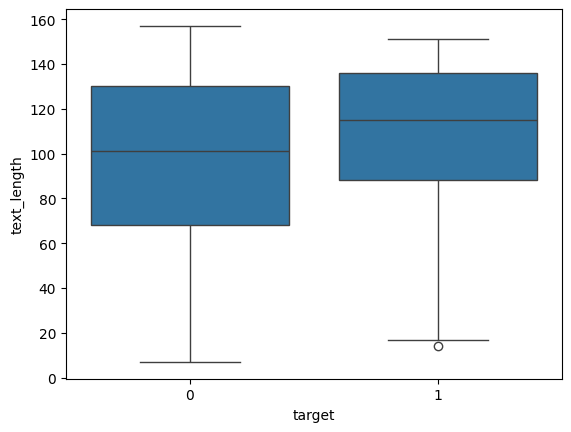

In [17]:
#cruce con variables de texto
df["text_length"] = df["text"].apply(len)
sns.boxplot(x="target", y="text_length", data=df)


En el gráfico de cruce con variables de texto de longitud de texto según la variable, lo que se puede observar es que la media de los tweets que no son de desastre tienen alrededor de una media de 50 caracteres. Mientras, los tweets con target 1, que indican un desastre real tienen una media más alta de 60 cáracteres, lo que puede indicar que los que describen un desastre real suelen ser más largos. Esto puede ser debido a que los tweets de desastres reales tienden a ser más largo porque den contexto como del lugar daños o personas.  

### 3. limpieza y preprocesamiento de los datos

In [18]:
import emoji
import string
import unicodedata

columnas_cat = df.select_dtypes(include=['object']).columns

important_numbers = {"911", "112", "999", "420", "19"}

def clean_text(text):

    text = text.lower()                                # minúsculas
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # quitar URLs
    text = re.sub(r"@\w+", "", text)                    # quitar menciones
    
    text = re.sub(r"#[\w-]+", "", text)                  # quitar hashtags

    text = re.sub(r"\d+", "", text)                       # quitar números

    text = re.sub(r"'\w+", "", text)                      # quitar apostrofes

    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # quitar URLs

    text = emoji.replace_emoji(text, replace="") #quitar emojis, al parecer tambien se puede con  text = re.sub(r"[^\x00-\x7F]+", "", text) 

    #fechas 12/05/2025, 2025-05-12
    text = re.sub(r"\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b", "<date>", text)

    # Horas  12:30, 23:59
    text = re.sub(r"\b\d{1,2}:\d{2}\b", "<time>", text)

    # Cantidades con K, M, % ( 100k, 5%, 2m)
    text = re.sub(r"\b\d+(k|m|%)\b", "<qty>", text)

    # Numeros en general: si es importante, mantenerlo si no, <num>
    def replace_numbers(match):
        num = match.group()
        return num if num in important_numbers else "<num>"

    text = re.sub(r"\b\d+\b", replace_numbers, text)

    #quitar acentos
    text = unicodedata.normalize("NFKD", text).encode("ASCII", "ignore").decode("utf-8", "ignore")

    text = text.translate(str.maketrans("", "", string.punctuation))  # quitar puntuación
    text = re.sub(r"\s+", " ", text).strip()  # quitar espacios extra

    #quitar la letra U sola, porque no es relevante
    text = re.sub(r"\bU\b|\bu\b", "", text)

    #quitar la palabra via
    text = re.sub(r"\bvia\b", "", text)

    #quitar la palabra amp
    text = re.sub(r"\bamp\b", "", text)

    #tokenizar
    tokens = text.split()
    #quitar stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df[columnas_cat] = df[columnas_cat].applymap(clean_text)
df

C:\Users\MSI\AppData\Local\Temp\ipykernel_13024\4145394944.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columnas_cat] = df[columnas_cat].applymap(clean_text)


,id,keyword,location,text,target,text_length
0,1,sin keyword,sin location,deeds reason may allah forgive us,1,69
1,4,sin keyword,sin location,forest fire near la ronge sask canada,1,38
2,5,sin keyword,sin location,residents asked place notified officers evacua...,1,133
3,6,sin keyword,sin location,people receive evacuation orders california,1,65
4,7,sin keyword,sin location,got sent photo ruby smoke pours school,1,88
...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding bridge collapse nearb...,1,83
7609,10870,sin keyword,sin location,control wild fires california even northern pa...,1,125
7610,10871,sin keyword,sin location,utckm volcano hawaii,1,65
7611,10872,sin keyword,sin location,police investigating ebike collided car little...,1,137


## Análisis Exploratorio de Texto 🔍

1. Revisemos las palabras más comunes en target = 1 y 0
2. Visualicemos estas palabras en **nubes de palabras** para entender mejor los patrones.  

In [19]:
# Texto combinado por clase
cols_wc = ["text", "keyword"]  # sin location
target1_words = df.loc[df.target==1, cols_wc].fillna("").agg(" ".join, axis=1).str.cat(sep=" ")
target2_words = df.loc[df.target==0, cols_wc].fillna("").agg(" ".join, axis=1).str.cat(sep=" ")


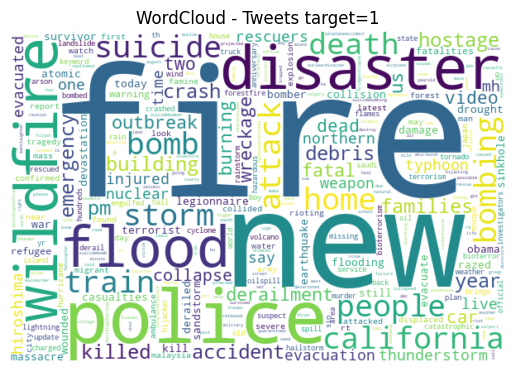

In [20]:
wc_params = dict(width=600, height=400, background_color="white",
                 collocations=False, max_words=300)

wordcloud_pos = WordCloud(**wc_params).generate(target1_words)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Tweets target=1")
plt.show()


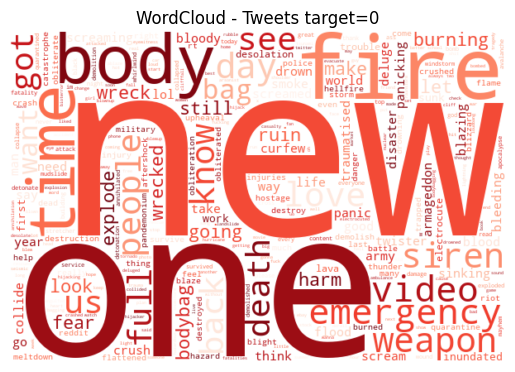

In [21]:
wordcloud_neg = WordCloud(**wc_params, colormap="Reds").generate(target2_words)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Tweets target=0")
plt.show()

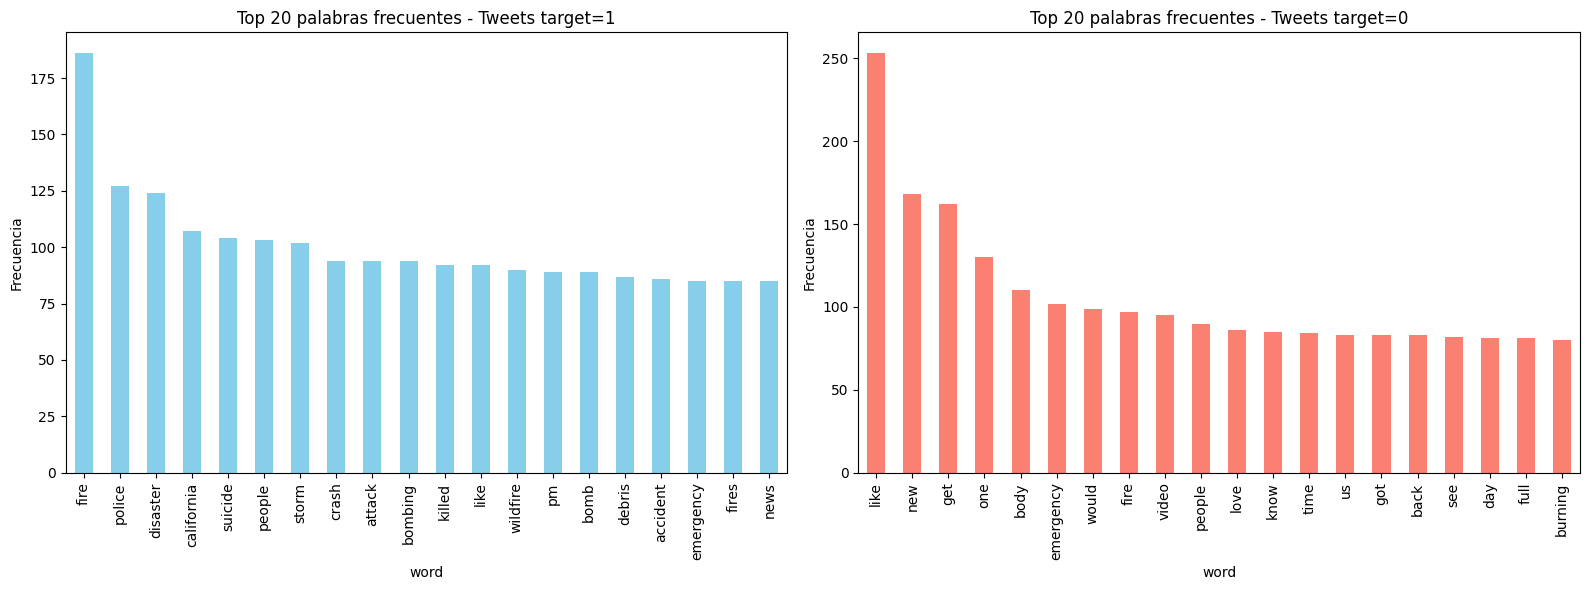

In [22]:
# Histogramas de frecuencias palabras individuales
from collections import Counter
import pandas as pd

target1_counts = Counter(target1_words.split())
target0_counts = Counter(target2_words.split())

df_target1 = pd.DataFrame(target1_counts.most_common(20), columns=['word', 'count'])
df_target0 = pd.DataFrame(target0_counts.most_common(20), columns=['word', 'count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_target1.plot.bar(x='word', y='count', ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Top 20 palabras frecuentes - Tweets target=1")
axes[0].set_ylabel("Frecuencia")

df_target0.plot.bar(x='word', y='count', ax=axes[1], color="salmon", legend=False)
axes[1].set_title("Top 20 palabras frecuentes - Tweets target=0")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()


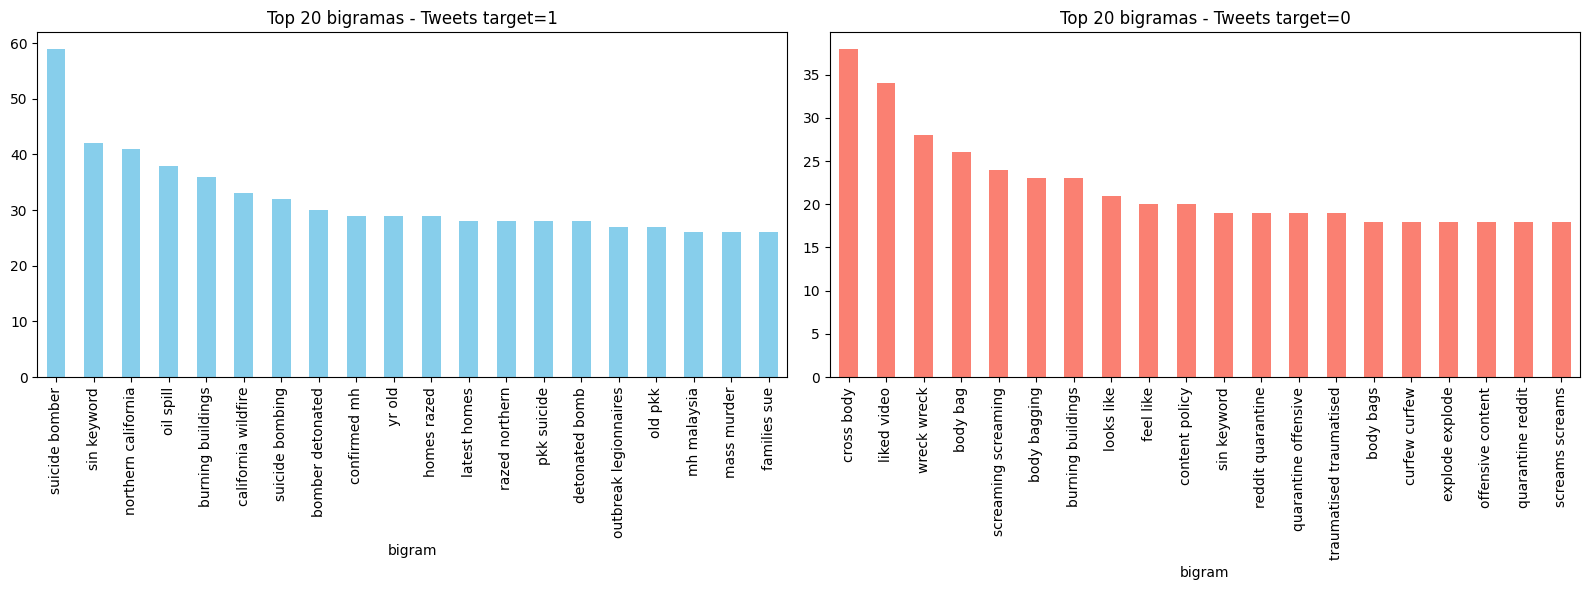

In [23]:
# Histogramas de frecuencias duplas de palabras

vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')

# Target 1
X1 = vectorizer.fit_transform([target1_words])
sum_words1 = X1.toarray().sum(axis=0)
words_freq1 = [(word, sum_words1[idx]) for word, idx in vectorizer.vocabulary_.items()]
df_bigram1 = pd.DataFrame(sorted(words_freq1, key=lambda x: x[1], reverse=True)[:20],
                          columns=['bigram','count'])

# Target 0
X0 = vectorizer.fit_transform([target2_words])
sum_words0 = X0.toarray().sum(axis=0)
words_freq0 = [(word, sum_words0[idx]) for word, idx in vectorizer.vocabulary_.items()]
df_bigram0 = pd.DataFrame(sorted(words_freq0, key=lambda x: x[1], reverse=True)[:20],
                          columns=['bigram','count'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df_bigram1.plot.bar(x='bigram', y='count', ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Top 20 bigramas - Tweets target=1")

df_bigram0.plot.bar(x='bigram', y='count', ax=axes[1], color="salmon", legend=False)
axes[1].set_title("Top 20 bigramas - Tweets target=0")

plt.tight_layout()
plt.show()


In [24]:
df[df["text"].str.contains("wreck wreck", case=False, na=False)]

,id,keyword,location,text,target,text_length
7472,10689,wreck,sin location,wreck wreck wreck wreck wreck wreck wreck wrec...,0,79
7487,10709,wreck,sin location,emotions train wreck body train wreck wreck,0,68


### Creacion de modelo de prediccion 

In [25]:
df

,id,keyword,location,text,target,text_length
0,1,sin keyword,sin location,deeds reason may allah forgive us,1,69
1,4,sin keyword,sin location,forest fire near la ronge sask canada,1,38
2,5,sin keyword,sin location,residents asked place notified officers evacua...,1,133
3,6,sin keyword,sin location,people receive evacuation orders california,1,65
4,7,sin keyword,sin location,got sent photo ruby smoke pours school,1,88
...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding bridge collapse nearb...,1,83
7609,10870,sin keyword,sin location,control wild fires california even northern pa...,1,125
7610,10871,sin keyword,sin location,utckm volcano hawaii,1,65
7611,10872,sin keyword,sin location,police investigating ebike collided car little...,1,137


In [26]:
vectorizer = CountVectorizer(ngram_range=(1,2))  # unigramas y bigramas
X = vectorizer.fit_transform(df["text"])
y = df["target"]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.81      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [28]:
cm = confusion_matrix(y_test,y_pred)
accuracy=accuracy_score(y_test,y_pred)

print('Matriz de confusión:\n',cm)
print('Accuracy: ',accuracy)

Matriz de confusión:
 [[1167  151]
 [ 303  663]]
Accuracy:  0.8012259194395797


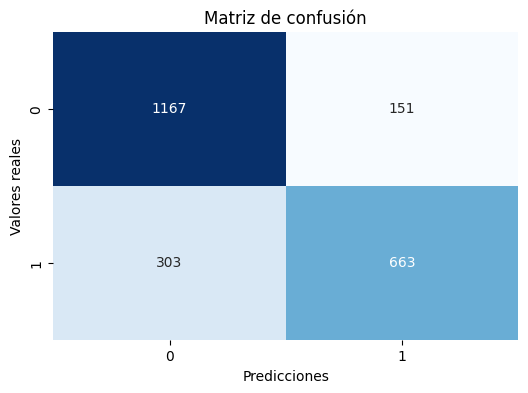

Accuracy: 0.8012259194395797
Precisión: 0.8025980963434053
Recall: 0.8012259194395797
F1-Score: 0.7981574549199746

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      1318
           1       0.81      0.69      0.74       966

    accuracy                           0.80      2284
   macro avg       0.80      0.79      0.79      2284
weighted avg       0.80      0.80      0.80      2284



In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' si hay varias clases
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generar matriz
cm = confusion_matrix(y_test, y_pred)

# Crear gráfico
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de confusión")
plt.show()

print("Accuracy:", accuracy)
print("Precisión:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))


In [30]:

def clean_text_series(series: pd.Series) -> pd.Series:
    def clean_one(t: str) -> str:
        if not isinstance(t, str):
            t = "" if pd.isna(t) else str(t)
        s = t.lower()
        s = re.sub(r"http[s]?://\S+|www\.\S+", " ", s)
        s = re.sub(r"@\w+", " ", s)
        s = re.sub(r"#", " ", s)
        s = re.sub(r"[\U00010000-\U0010ffff]", " ", s)
        s = s.replace("’","'")
        s = re.sub(r"[^a-z0-9\s]", " ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s
    return series.astype(str).apply(clean_one)

pipe = Pipeline([
    ("clean", FunctionTransformer(clean_text_series, validate=False)),
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=40000)),
    ("clf", LinearSVC(random_state=42)),
])

# Asumiendo que tu DataFrame principal se llama df y tiene columnas ['text','target']
X_train, X_val, y_train, y_val = train_test_split(
    df["text"].astype(str), df["target"].astype(int),
    test_size=0.2, random_state=42, stratify=df["target"].astype(int)
)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("F1(1):", f1_score(y_val, y_pred))
print("F1-macro:", f1_score(y_val, y_pred, average="macro"))
print(classification_report(y_val, y_pred, digits=4))


Accuracy: 0.7846355876559422
F1(1): 0.7461300309597523
F1-macro: 0.7795644453544486
              precision    recall  f1-score   support

           0     0.8056    0.8205    0.8130       869
           1     0.7555    0.7370    0.7461       654

    accuracy                         0.7846      1523
   macro avg     0.7806    0.7787    0.7796      1523
weighted avg     0.7841    0.7846    0.7843      1523



In [31]:
def clasificar_dataframe(modelo, df_in, text_col='text'):
    X = df_in[text_col].astype(str)
    out = df_in.copy()
    out["pred"] = modelo.predict(X).astype(int)
    return out

df_pred = clasificar_dataframe(pipe, df, text_col="text")

# Guardar archivos
df_pred[ [c for c in ["id","keyword","location","text","target"] if c in df_pred.columns] + ["pred"] ] \
    .to_csv("predicciones_tweets.csv", index=False, encoding="utf-8")

if "id" in df_pred.columns:
    df_pred[["id","pred"]].rename(columns={"pred":"target"}).to_csv("submission.csv", index=False, encoding="utf-8")
